In [ ]:
## @see https://www.kaggle.com/toorkp/churn-wsdm/data

In [1]:
%load_ext autoreload
%autoreload

In [5]:
"test"

'test'

In [2]:
import numpy as np
import pandas as pd
import time
import gc; gc.enable()
import time
import sys

from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from collections import Counter
from numpy.random import RandomState
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

pd.options.display.float_format = "{:.2f}".format
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('modules')

from shared_functions import *

import pickle
from datetime import datetime

/home/anaconda/envs/py373/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
# Load the pre-split data

store = pd.HDFStore('/home/dissertation/data/base_abt_split.h5')
X_train, X_test, y_train, y_test = store['X_train'], store['X_test'], store['y_train'], store['y_test']
store.close()

print("Train Shape:", X_train.shape, y_train.shape)
print("Train Shape:", X_test.shape, y_test.shape)
X_train.head()

Train Shape: (600803, 16) (600803,)
Train Shape: (257487, 16) (257487,)


,msno,city,bd,registered_via,registration_init_time,registration_init_time_dt,total_order,payment_method_id_mode,payment_method_id_count,payment_plan_days_mode,payment_plan_days_mean,plan_list_price_mean,plan_lifetime_value,is_auto_renew_mode,transaction_date_max,cancel_times
703741,k5508nHWp+WmOeQTuChB4ETVmbhFmA+7E0qgK1uXKEg=,4,32,3,20130407,2013-04-07,22,33,1,30,21.82,108.36,2384.00,True,20170228,0
228194,WiRqDxpeBqgkDSqd3kRG/VgZbbDUh7yjxHquuY+iVbY=,13,33,3,20131125,2013-11-25,19,39,1,30,28.58,141.16,2682.00,True,20170131,0
735733,YVVOQPk0x2NeB3WqLgc9Sp1R8rIbaWDAnXAZFOf7rlY=,15,22,3,20150705,2015-07-05,17,40,3,30,30.00,158.12,2688.00,True,20170210,4
774256,pm07iNhaXPZ3On4cr4xyL4qOETYWikeemBOHZKhvzYI=,1,0,7,20140806,2014-08-06,26,41,1,30,28.85,143.27,3725.00,True,20170205,0
282188,MboyMUzNIj6LN+wDrZai6uLE3XQ0ReA79JSMNZfkLgk=,1,0,7,20121026,2012-10-26,27,41,1,30,28.89,132.00,3564.00,True,20170216,1


In [4]:
## Set the list of the categorical columns in the dataset
cat_col = ['city', 'registered_via', 'payment_method_id_mode']

# Drop msno from the dataset
X_train.drop(['msno'], inplace=True, axis=1)
X_test.drop(['msno'], inplace=True, axis=1)

In [5]:
RANDOM_STATE = 42 
CV_ITER = 5
SCORING_METRIC = 'recall'

BASE_NAME = "basic_" + str(CV_ITER) + "cv_" + SCORING_METRIC

## Each entry in the list is a Tuple of
##   [ModelName, Model, HyperParams, ScoringMetric]
classifiers = [
    ('NB_' + BASE_NAME, GaussianNB(), {}, SCORING_METRIC),
    ('DT_' + BASE_NAME, DecisionTreeClassifier(), {}, SCORING_METRIC),
    ('RF_' + BASE_NAME, RandomForestClassifier(n_jobs =-1), {}, SCORING_METRIC),
    ('LR_' + BASE_NAME, LogisticRegression(solver = 'liblinear'), {}, SCORING_METRIC),
    ('AB_' + BASE_NAME, AdaBoostClassifier(), {}, SCORING_METRIC),
    ('MLP_' + BASE_NAME, MLPClassifier(), {}, SCORING_METRIC),
    ('XGB_' + BASE_NAME, xgb.XGBClassifier(objective="binary:logistic"), {}, SCORING_METRIC) 
]

In [6]:
all_metrics = pd.DataFrame()
all_results = list()

### Experiment 1.x Baseline - Default Settings - No sampling - 10 iterations to test score variance

In [ ]:
# %%time

# N_ITERATIONS = 10
# RANDOM_STATE = None

# sampler = ('None', DummySampler())

# exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, N_ITERATIONS, \
#                                                 cv_iter=CV_ITER, cat_col=cat_col)


### Is it possible to test RandomSampling and the effect of random_state ?????

In [ ]:
# %%time

# N_ITERATIONS = 10
# RANDOM_STATE = None

# sampler = ('None', RandomOverSampler(random_state=None))

# exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, N_ITERATIONS, \
#                                                 cv_iter=CV_ITER, cat_col=cat_col)


In [ ]:
#  Over 10 iterations we have 0 difference in accuracy, precision, recall, f1_score, aucroc, aucprc
#    Small difference in balanced accuracy of 0.01. 
#    A 5-fold CV recall score on the test set shows a mean of 0.45 with SD of 0.01.
#    Churn cost changes minimally (M: 8680470.0, SD: 6398.132540046353, Pct Cost of 1 SD: 0.07%))
    
#    np.mean(exp_metrics.model_churn_cost.values),  np.std(exp_metrics.model_churn_cost.values)
#    100 * (np.std(exp_metrics.model_churn_cost.values) / np.mean(exp_metrics.model_churn_cost.values))    

#exp_metrics

### Experiment 1.1 Baseline - Default Settings - No sampling

Model Build Iteration 0
PRE-SAMPLING: (600803, 15) (600803,) Counter({0: 544661, 1: 56142})
POST-SAMPLING: (600803, 15) (600803,) Counter({0: 544661, 1: 56142})
Set the train df types correctly based on the test set
Applying normalisation to train and test sets
Categorical columns in dataset ['city', 'registered_via', 'payment_method_id_mode']
Categorical columns in dataset ['city', 'registered_via', 'payment_method_id_mode']
X_train:  (600803, 70) (600803, 1)
X_test:  (257487, 70) (257487, 1)


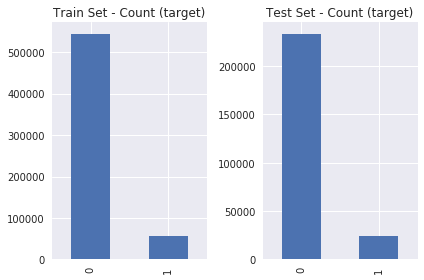

Training NB_basic_5cv_recall classifier
No params set, using Standard training
Generating test scores for NB_basic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training DT_basic_5cv_recall classifier
No params set, using Standard training
Generating test scores for DT_basic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training RF_basic_5cv_recall classifier
No params set, using Standard training


/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Generating test scores for RF_basic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training LR_basic_5cv_recall classifier
No params set, using Standard training
Generating test scores for LR_basic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric


/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training AB_basic_5cv_recall classifier
No params set, using Standard training
Generating test scores for AB_basic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training MLP_basic_5cv_recall classifier
No params set, using Standard training
Generating test scores for MLP_basic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric


In [ ]:
%%time

sampler = ('None', DummySampler())

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

### Experiment 1.2 Baseline - Default Settings - Oversampled training set 100%

In [ ]:
%%time

sampler = ('ROS 1:1', RandomOverSampler(random_state=RANDOM_STATE))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, 
                                 cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

### Experiment 1.3 Baseline - Default Settings - Undersampled training set

In [ ]:
%%time

sampler = ('RUS 1:1', RandomUnderSampler(random_state=RANDOM_STATE))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, 
                                 cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

### Experiment 1.4 Baseline - Default Settings - Over sampling - 33% of majority size

In [ ]:
%%time

sampler = ('ROS 3:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/3))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, 
                                 cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

### Experiment 1.5 Baseline - Default Settings - Over sampling - 66% of majority size

In [ ]:
%%time

sampler = ('ROS 3:2', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 2/3))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, 
                                 cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

### Experiment 1.6 Baseline - Default Settings - Over sampling - 50% of majority size

In [ ]:
%%time

sampler = ('ROS 2:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/2))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, 
                                 cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

### Experiment 1.7 Baseline Default Settings SMOTE-NC

In [ ]:
%%time

sampler = ('SMOTE_NC', SMOTENC(random_state=RANDOM_STATE, categorical_features=[0,1,2,3,4,5,6,7,12,13], n_jobs=8))

## Keep the following, essentially dropping the dt columns
cols = ['is_churn', 'city', 'bd', 'registered_via', 'total_order',
       'payment_method_id_mode', 'payment_method_id_count',
       'payment_plan_days_mode', 'payment_plan_days_mean',
       'plan_list_price_mean', 'plan_lifetime_value', 'actual_amount_mean',
       'total_actual_amount', 'is_auto_renew_mode', 'cancel_times']

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, 
                                 cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

### Persist results to disk

In [22]:
store(all_results, 'Basic_DefaultHyper_{0}.pickle'.format(datetime.today().strftime('%Y-%m-%d')))

Writing results to Basic_DefaultHyper_2019-08-02.pickle


In [23]:
# with open('EXP1_2019-07-31.pickle', 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     data = pickle.load(f)
    
# data[0][1][1][2]

### Sort the results and get the best sampling config per classifier 

In [24]:
top_results = all_metrics.sort_values(['balanced_accuracy'], ascending=[False]).groupby('classifier').head(1)
top_results

,label,classifier,sampling_method,tn,fn,tp,fp,accuracy,precision,recall,...,log_loss,train_time,cv_time,aucroc,auprc,balanced_accuracy,cv_score_mean,cv_score_std,model_churn_cost,sample
0,XGB_basic_5cv_recall,XGBClassifier,ROS 1:1,204794,6209,17852,28632,0.86,0.38,0.74,...,4.67,161.54,41.28,0.88,0.62,0.81,0.39,0.01,7752900,0
0,AB_basic_5cv_recall,AdaBoostClassifier,RUS 1:1,202536,6130,17931,30890,0.86,0.37,0.75,...,4.97,49.89,55.57,0.87,0.57,0.81,0.36,0.01,7947100,0
0,RF_basic_5cv_recall,RandomForestClassifier,RUS 1:1,193777,5735,18326,39649,0.82,0.32,0.76,...,6.09,2.98,7.12,0.87,0.56,0.80,0.42,0.01,8665000,0
0,DT_basic_5cv_recall,DecisionTreeClassifier,RUS 1:1,187496,6274,17787,45930,0.80,0.28,0.74,...,7.00,2.60,5.05,0.76,0.49,0.77,0.45,0.01,9508700,0
0,NB_basic_5cv_recall,GaussianNB,SMOTE_NC,208184,8705,15356,25242,0.87,0.38,0.64,...,4.55,6.03,3.19,0.81,0.55,0.77,0.53,0.00,8412300,0
0,LR_basic_5cv_recall,LogisticRegression,RUS 1:1,189348,10772,13289,44078,0.79,0.23,0.55,...,7.36,2.26,2.85,0.74,0.38,0.68,-1.00,-1.00,11122700,0
0,MLP_basic_5cv_recall,MLPClassifier,SMOTE_NC,233426,24061,0,0,0.91,0.00,0.00,...,3.23,1569.94,764.33,0.50,0.55,0.50,-1.00,-1.00,12030500,0


### Graph the results base on the list of best classifiers above

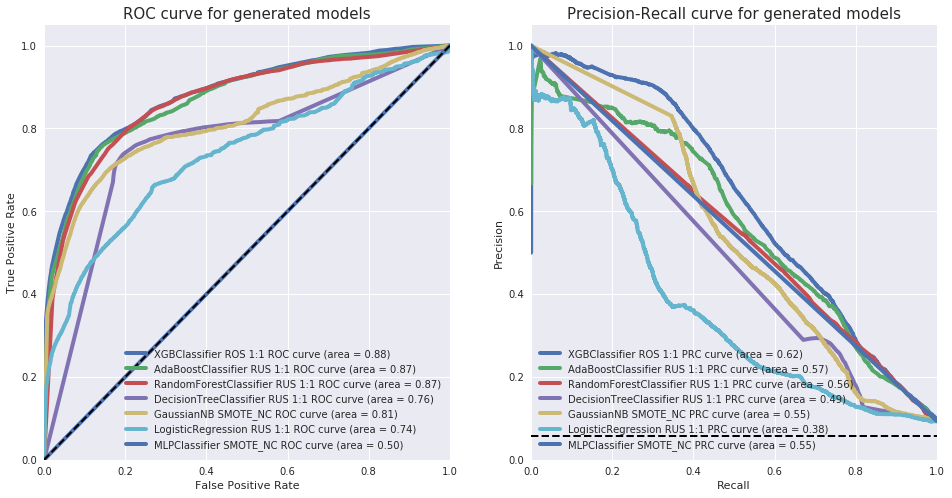

In [25]:
temp = filter_top_model_results(top_results, all_results)
plot_roc_prc(temp)

### How long did each of these actually take ...

In [ ]:
all_metrics.sort_values(['auprc', 'recall'], ascending=[False, False]).head(15)

In [ ]:
ordered_features

In [ ]:
## Print the permutation importance 

import eli5
from eli5.sklearn import PermutationImportance

_, X_test, _, y_test = prepare_train_test_split(model_dataset, 0)

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [ ]:
#model_name, model = model_train_results[1][2]

for model_name, model in model_train_results[1]:
    probs = model.predict_proba(X_test)[:, 1]
    pr_data = plot_precision_recall(
        y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
pr_data = plot_roc(
    y_test, probs, title='ROC Curve for {0}'.format(model_name))

In [ ]:
print(plt.style.available)

In [ ]:
model_dataset.head()

In [ ]:
print("Original Data distribution")
print(model_dataset['is_churn'].value_counts())

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Down Sampled data set')
train_downsample = undersampled_dataset(model_dataset, 'is_churn')

print(train_downsample['is_churn'].value_counts())
print("Num records = ", train_downsample.shape[0])
train_downsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Up Sampled data set')
train_upsample = oversampled_dataset(model_dataset, 'is_churn')

print(train_upsample['is_churn'].value_counts())
print("Num records = ", train_upsample.shape[0])
train_upsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='Precision-Recall Curve for Random Forest')

In [ ]:
precision_above = pr_data.loc[pr_data['precision'] >= 0.25].copy()
precision_above.sort_values('recall', ascending=False, inplace=True)
precision_above.head()

In [ ]:
threshold_required = 0.5
# Make predictions where probability is above threshold
preds = np.zeros(len(y_test))
preds[probs >= threshold_required] = 1

# Make and plot confusion matrix
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'],
                      title='Churn Confusion Matrix')

In [ ]:
model_dataset.head()

In [ ]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=model_dataset.iloc[:, 1:].columns).\
    sort_values('importance', ascending=False)
fi.head(10)